# 

# 5. 예측 성능 평가

In [1]:
#!pip install dmba
import math
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pylab as plt

import dmba
from dmba import regressionSummary, classificationSummary, liftChart, gainsChart

%matplotlib inline

## 예측 성능의 평가
* 예측 정확성 != 적합도
    * 전통적인 통계적 성능 척도
        * 학습된 데이터에 적합한 모델을 찾는 것을 목표로 함
        * $R^2$, 표준추정오차, 잔차분석
    * 데이터마이닝
        * 새로운 레코드에 적용했을 때 예측 정확성이 높은 모델에 관심이 있음

* 예측 성능 평가
    * 검증 데이터(validation data)를 기반으로 모든 케이스에 대해 예측 정확도를 평가해 학습 데이터보다 좀 더 객관적인 근거 제공

* 지도 학습에서 관심 결과
    * 수치 값: 결과 변수가 수치형일 때(주택 가격)
    * 클래스 소속도: 결과 변수가 범주형일 때(구매자/비구매자)
    * 경항: 결과 변수가 범주형일 때(채무 불이행 경향) 클래스 소속되의 확률

### 나이브 벤치마크: 평균
* 예측에서 벤치마크는 평균 결과 값을 기준으로 사용함
    * 새로운 레코드에 대한 예측은 학습 데이터셋($\bar{y}$)레코드에 대한 결과 값의 평균
    * 이를 나이브 벤치마크라고 부르기로 함
    * 좋은 모델은 예측의 정확성 면에서 벤치마크 기준을 넘어서야 함
    
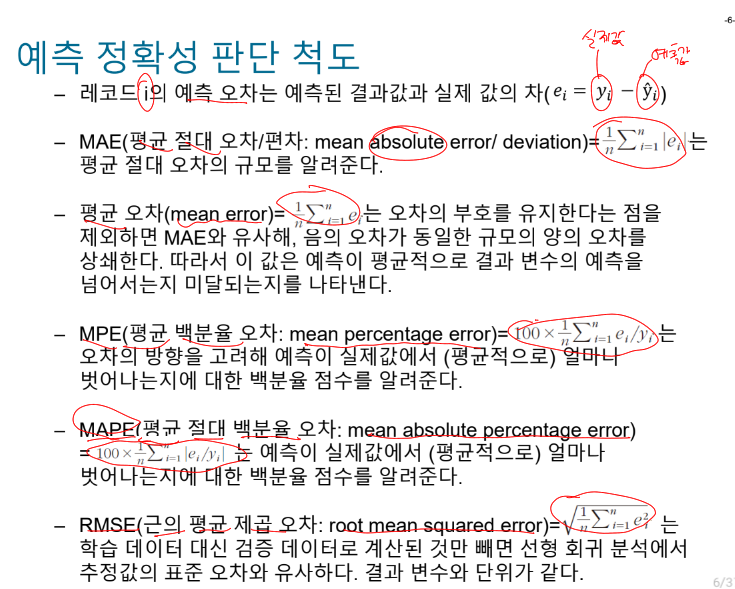

In [2]:
# Load data frame and select columns for regression analysis
car_df = dmba.load_data('ToyotaCorolla.csv')
#car_df=pd.read_csv('ToyotaCorolla.csv')

# create a list of predictor variables by remvoing output variables and text columns
excludeColumns = ('Price', 'Id', 'Model', 'Fuel_Type', 'Color')
predictors = [s for s in car_df.columns if s not in excludeColumns]
outcome = 'Price'

# partition data
X = car_df[predictors]
y = car_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# train linear regression model
reg = LinearRegression()
reg.fit(train_X, train_y)

# evaluate performance
# training
regressionSummary(train_y, reg.predict(train_X))
# validation
regressionSummary(valid_y, reg.predict(valid_X))


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 1121.0606
            Mean Absolute Error (MAE) : 811.6770
          Mean Percentage Error (MPE) : -0.8630
Mean Absolute Percentage Error (MAPE) : 8.0054

Regression statistics

                      Mean Error (ME) : 97.1891
       Root Mean Squared Error (RMSE) : 1382.0352
            Mean Absolute Error (MAE) : 880.1396
          Mean Percentage Error (MPE) : 0.0138
Mean Absolute Percentage Error (MAPE) : 8.8744


### 학습과 검증 성능의 비교
* 학습 데이터셋에서 오차는 모델이 얼마나 잘 적합되었는지를 알려줌
* 반면, 검증 데이터셋에서 오차(예측 오차)는 모델이 새로운 데이터를 예측하는 성능(예측 성능)을 측정
* 모델은 학습 데이터셋을 사용해 적합되었기 때문에 학습 오차가 검증 오차보다 작고, 복잡한 모델일수록 학습 데이터에 과적합될 가능성이 더 큼(학습 오차와 검증 오차의 차가 더 커지는 것으로 나타남)

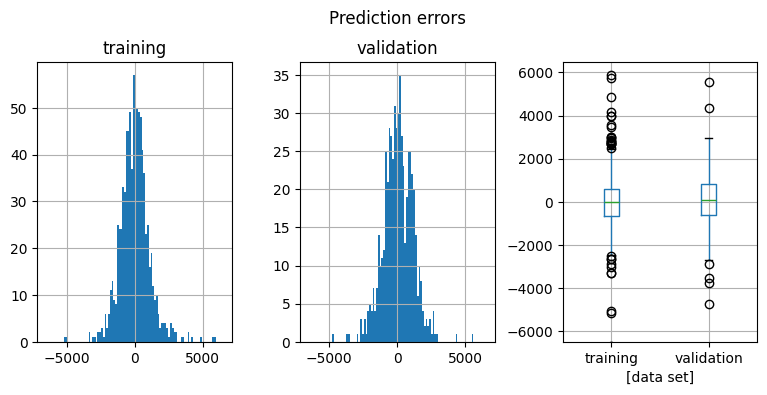

In [3]:
pred_error_train = pd.DataFrame({
    'residual': train_y - reg.predict(train_X),
    'data set': 'training'
})
pred_error_valid = pd.DataFrame({
    'residual': valid_y - reg.predict(valid_X),
    'data set': 'validation'
})
boxdata_df = pd.concat([pred_error_train, pred_error_valid])

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(9, 4)
common = {'bins': 100, 'range': [-6500, 6500]}
pred_error_train.hist(ax=axes[0], **common)
pred_error_valid.hist(ax=axes[1], **common)
boxdata_df.boxplot(ax=axes[2], by='data set')

axes[0].set_title('training')
axes[1].set_title('validation')
axes[2].set_title(' ')
axes[2].set_ylim(-6500, 6500)
plt.suptitle('Prediction errors')
plt.subplots_adjust(bottom=0.15, top=0.85, wspace=0.35)

plt.show()

### 누적 이득과 리프트 차트
* 새로운 레코드에서 단지 누적 예측값이 가장 큰 레코드들의 부분집합을 찾을 때 예측 성능을 시각적으로 측정하는 방법: **누적 이득 차트**와 **리프트 차트** 이용
* 예측값이 높은 값부터 낮은 값으로 정렬된 관심 레코드들(보통 검증 데이터)의 실제 값들을 누적시키고 누적된 레코드의 수(x축값)에 대한 함수로 y축에 그 누적값(이득)을 그리는 것이 누적 이득 차트(곡선)
* 누적 이득 차트가 벤치마크 대각선에서 멀리 떨어질수록 모델이 높은 결과 값의 레코드들과 낮은 결과 값의 레코드들을 더 잘 분리함
* 같은 정보가 십분위 리프트차트에서도 나올 수 있는데, 이 차트는 정렬된 레코드들을 10개의 십분위로 그룹하하고 각 십분위에 대해 나이브 벤치마크 이득에 대한 모델의 이득비(리프트비라고 불림)를 보여줌

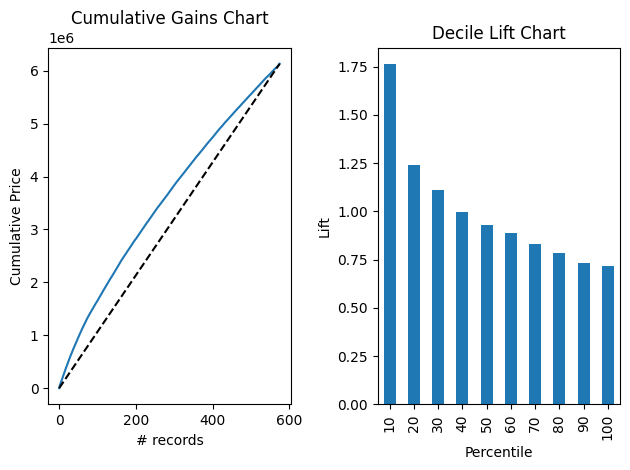

Lift based on meanResponse 1.7618191980414206
Expected cumulative price for 10% random sales 613291.8
Cumulative price for top 10% sales 1089905
Lift calculated based on gains chart 1.777139364980911


In [4]:
# sort the actual values in descending order of the prediction
df = pd.DataFrame({
    'predicted': reg.predict(valid_X),
    'actual': valid_y,
})
df = df.sort_values(by=['predicted'], ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(df['actual'], ax=axes[0])
ax.set_ylabel('Cumulative Price')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(df['actual'], ax=axes[1], labelBars=False)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show()


# group the sorted predictions into 10 roughly equal groups and calculate the mean
sorted_act_v = df['actual']
groups = [int(10 * i / len(sorted_act_v)) for i in range(len(sorted_act_v))]
meanPercentile = sorted_act_v.groupby(groups).mean()
meanResponse = meanPercentile / sorted_act_v.mean()
meanResponse.index = (meanResponse.index + 1) * 10
print('Lift based on meanResponse', meanResponse[10])
random10 = sorted_act_v.cumsum().iloc[-1] / 10  # expected cumulative price without lift for 10% sales
cumPred10 = sorted_act_v.cumsum().iloc[57]  # cumulative price based on model for top 10%
print('Expected cumulative price for 10% random sales', random10)
print('Cumulative price for top 10% sales', cumPred10)
print('Lift calculated based on gains chart', cumPred10 / random10)

* 가장 높게 판매 예측이 되는 자동차들의 상위 10%르 선택하면 임의의 10% 자동차를 선택하는 것에 비해서 1.75배 높은 수익을 얻을 것이다.
* 이 수치는 임의의 57대 자동차의 판매 금액(x=57에서 기준선의 값)인 607703달러(=575대의 검증 데이터셋 자동차의 실제 판매액의 합을 10으로 나눈 값)와
* 예측값이 가장 높은 57대 자동차의 실제 판매액(x=57에서 누적 이득 차트의 값)인 1073830달러를 비교해서 얻는다. 이 수치들의 비율은 1.76이다.

## 분류기 성능의 판단
### 벤치마크: 나이브 규칙
* 해당 레코드를 다수 클래스의 멤버로 분류
* 종종 벤치마크로 사용됨
* 수치 결과의 경우에 표본 평균($\bar{y}$)을 나이브 벤치마크로 사용한 것과 유사하게, 분류를 위한 나이브 규칙은 추가적인 예측 변수 정보는 배제하고 y 정보에만 의존한다.

### 클래스 분리
* (a)는 두 예측변수가 소유자와 비소유자를 분리하기 위해 사용된 작은 데이터셋을 보여준다.(고수준의 분리)
* (b)는 2개의 예측변수가 대부분의 높은 범위에서 2개의 클래스(대부분 수용자/비수용자)를 잘 분리하지 못하는 훨씬 큰 데이터셋을 보여준다.(저수준의 분리)

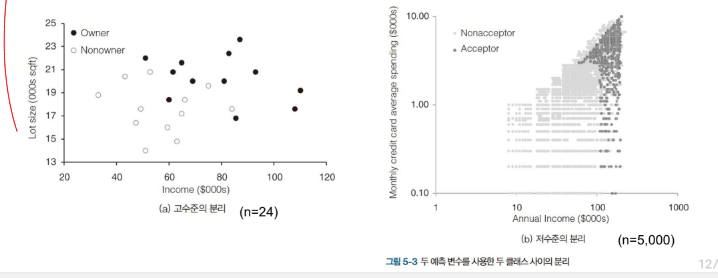

### 정오(분류) 행렬
* 특정 데이터셋에 대해 산출하는 정확한 분류와 부정확한 분류를 요약
* 정오 행렬의 행과 열은 각각 예측 클래스와 진(실제) 클래스에 대응
* 미래 분류 오차의 정확한 추정값을 얻기 위해 검증 데이터로 계산된 정오 행렬을 사용함
    * 레코드들을 먼저 랜덤하게 추출해 학습 데이터셋과 검증 데이터셋으로 데이터 분할
    * 학습 데이터를 사용해 분류기를 구축한 후 검증 데이터에 적용
        * 학습 데이터에 대해서도 정오 행렬로 결과를 요약할 수 있지만, 과적합의 위험성 때문에 그 정오행렬의 결과는 새로운 데이터에 대한 오분류율의 솔직한 추정값을 얻기에는 유용하지 않음
    * 새로운 데이터 분류 성능을 평가하기 위해 검증 데이터 정오행렬을 검토하는 것과 더불어, 과적합을 검출핟기 위해 학습 데이터 정오행렬과 검증 데이터 정오 행렬을 비교

### 정확성 척도들
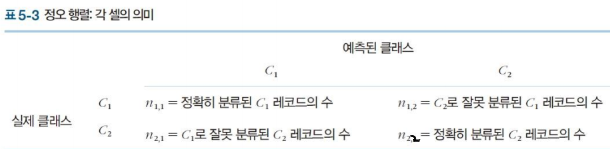

* 클래스 C1과 C2(예: 구매자와 비구매자)로 구성된 2-클래스 문제를 생각해보자.
* 표 5-3의 개념적 정오 행렬은 클래스 Ci의 일원이면서 Cj의 일원으로 분류된 경우의 수를 나타내기 위해 표기 $n_{i, j}$를 사용한다.
* 물론 i!=j이면 이것은 오분류의 수가 된다.
* 레코드들의 전체 수는 $n=n_{1, 1}+n_{1, 2}+n_{2, 1}+n_{2, 2}$다.

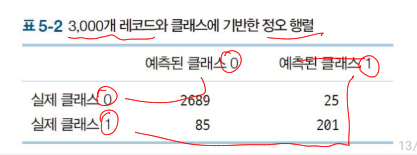
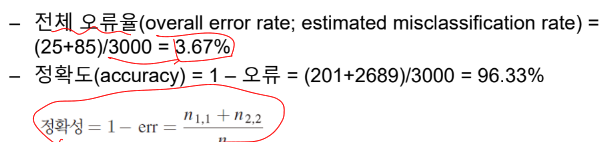

### 분류의 경향과 컷오프(threshold)
* 경향: 레코드가 각 클래스에 속할 확률
* (1) 예측된 클래스 소속도(분류)를 생성하거나 (2) 레코드들을 관심 클래스에 속할 확률로 순위를 정하기 위해 사용
* 2-클래스 분류기의 기본 컷오프 값은 0.50(다른 컷오프 값 사용 가능)

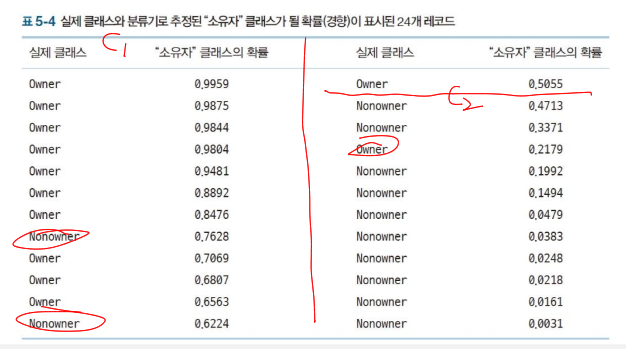

In [5]:
owner_df = dmba.load_data('ownerExample.csv')
owner_df.head()
class_names = ['nonowner', 'owner']

In [6]:
#cutoff=0.5
predicted = ['owner' if p > 0.5 else 'nonowner' for p in owner_df.Probability]
classificationSummary(owner_df.Class, predicted, class_names=class_names)

Confusion Matrix (Accuracy 0.8750)

         Prediction
  Actual nonowner    owner
nonowner       10        2
   owner        1       11


In [7]:
#cutoff=0.25
predicted = ['owner' if p > 0.25 else 'nonowner' for p in owner_df.Probability]
classificationSummary(owner_df.Class, predicted, class_names=class_names)

Confusion Matrix (Accuracy 0.7917)

         Prediction
  Actual nonowner    owner
nonowner        8        4
   owner        1       11


In [8]:
#cutoff=0.75
predicted = ['owner' if p > 0.75 else 'nonowner' for p in owner_df.Probability]
classificationSummary(owner_df.Class, predicted, class_names=class_names)

Confusion Matrix (Accuracy 0.7500)

         Prediction
  Actual nonowner    owner
nonowner       11        1
   owner        5        7


* 오분류율이 높아지는데도 0.5가 아닌 다른 값을 컷오프 값으로 사용하는 이유: 
    * 소유자를 비소유자보다 적절히 분류하는 것이 더 중요해서 후자의 좀 더 큰 오분류에 관대할 수 있기 때문. 다시 말해 오분류율의 비용이 비대칭적일 수 있음

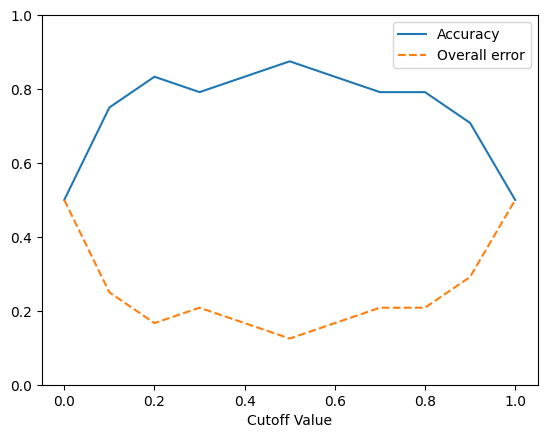

In [9]:
df = dmba.load_data('liftExample.csv')

cutoffs = [i * 0.1 for i in range(0, 11)]
accT = []
for cutoff in cutoffs:
    predicted = [1 if p > cutoff else 0 for p in df.prob]
    accT.append(accuracy_score(df.actual, predicted))

line_accuracy = plt.plot(cutoffs, accT, '-', label='Accuracy')[0]
line_error = plt.plot(cutoffs, [1 - acc for acc in accT], '--', label='Overall error')[0]
plt.ylim([0,1])
plt.xlabel('Cutoff Value')
plt.legend(handles=[line_accuracy, line_error])

### 클래스의 중요성이 불균등한 경우의 성능
* C1클래스의 소속도를 C2 클래스보다 정확하게 예측하는 것이 더 중요하다고 가정
    * 예: 회사의 재무상태(파산/상환 가능)를 예측하는 경우
         * 주어진 회사가 파산알지를 정확히 예측하는 것이 그 회사가 상환 능력을 유지할지 정확히 예측하는 것보다 더 중요할 수 있음
         * 이 분류기는 파산을 감지하거나 경고하기 위한 시스템으로 사용가능
         * 이러한 경우, 전체 정확도는 분류기를 평가하는 좋은 척도가 아니며, 중요한 클래스를 C1이라고 가정할 때, 다음의 정확성 척도쌍이 널리 사용됨
            * 분류기의 민감도: 중요한 클래스의 멤버를 올바르게 알아내는 능력, 정확하게 분류된 C1 멤버의 비율인 $n_{1, 1}/(n_{1, 1}+n_{1, 2})$로 측정
            * 분류기의 특이도: C2 멤버를 정확하게 제외하는 능력. 정확하게 분류된 C2멤버의 비율인 $n_{2, 2}/(n_{2, 1}+n_{2, 2})$로 측정

* 척도들의 균형을 맞추는 컷오프 값을 찾기 위해 컷오프 값에 대한 이 척도들을 그려보는 게 유용하고 널리 사용되는 방법은 ROC 커브
    * ROC곡선은 왼쪽 아래에서 시작해 컷오프 값을 1에서 0으로 줄이면서 {민감도, 특이도}쌍을 그린 것
    * ROC곡선을 요약하는 척도는 '곡선 아래 영역(AUC)'인데, 1(클래스들 사이의 완벽한 구별)에서 0.5(임의 추측보다 좋지 않음)사이의 값을 가짐

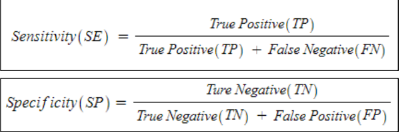

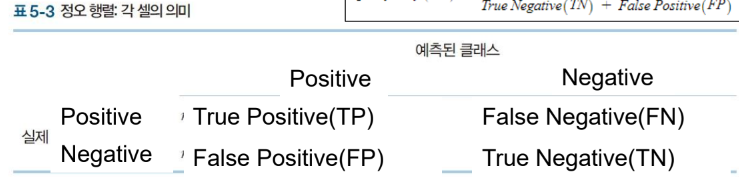

In [10]:
fpr, tpr, _ = roc_curve(df.actual, df.prob)
roc_auc = auc(fpr, tpr)

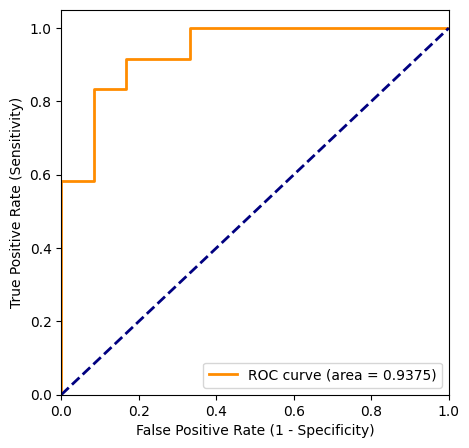

In [11]:
plt.figure(figsize=[5, 5])
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")

plt.show()

### 비대칭적 오분류 비용
* 1000명에게 추가로 우편물을 보내 평균적으로 1%가 응답(1) 했다고 가정
    * 모든 사람을 단순하게 0으로 분류하면 오차율은 1%
    * 이 분류의 오차율은 $100 * (20+2) / 1000=2.2%$로 나이브 규칙보다 높음

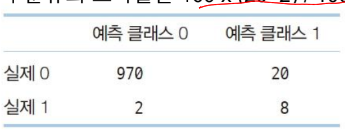

* 응답자 한 명에게 얻을 수 있는 이득: \$10, 우편물 발송 비용: \$1
* 이득 측면
    * 0으로 예측된 사람에게는 아무것도 보내지 않아 그 열에는 비용도 판매도 없음
    * 오분류율이 높더라도 \$60 이득(=\$80-\$20)

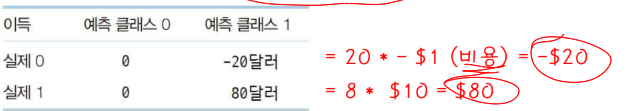

* 1000명에게 추가로 우편물을 보내 평균적으로 1%가 응답(1)했다고 가정
    * 모든 사람을 단순하게 0으로 분류하면 오차율은 1%
    * 이 분류의 오차율은 $100*(20+2)/1000=2.2%$로 나이브 규칙보다 높음
* 응답자 한 명에게서 얻을 수 있는 이득: \$10/ 우편물 발송 비용: \$1
* 비용 측면
    * 모든 사람이 0으로 분류되면 우편물 비용은 없고 유일한 비용은 판매 실패에 따른 기회비용
    * 우편물을 보낼 사람을 선택하기 위해 데이터마이닝 방법을 사용할 때 비용: \$48(우편물 발송비용+누락판매의 기회 비용)

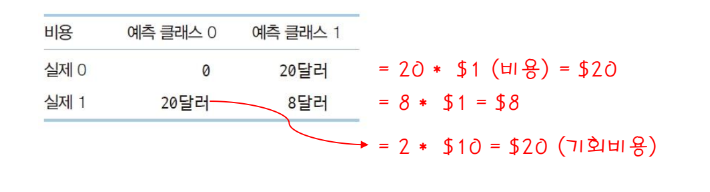

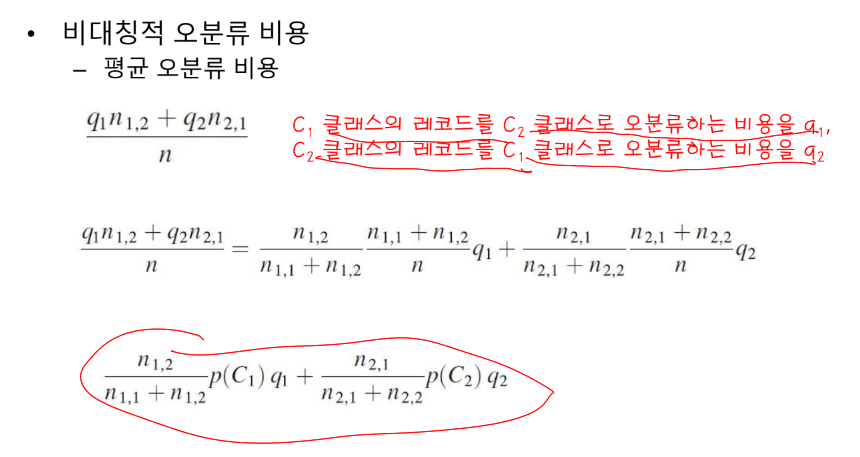

### 2개 이상의 클래스로 일반화하기
* 2-클래스 분류기에 대한 내용이 2개 이상의 클래스로 분류 하는 경우로 확장하여
* m개의 클래스 C1, C2, ..., Cm이 있다고 가정. 정오 행렬은 m행 m열
* m-클래스의 경우에 오분류 유형은 m(m-1)가지

## 랭킹 성능의 판단
* 새로운 레코드에서 관심 클래스에 속할 가능성이 가장 큰 것들을 탐지하는 예측작업
* 상대적으로 희귀한 특정 클래스에 다른 클래스보다 훨씬 더 관심이 있는 경우(탈세, 채무 불이행, 우편물 홍보에 대한 응답)
    * 탈세를 찾는다면, 어떤 세금 신고를 얼마나 많이 검토해야 할지 결정할 수 있음
        * 탈세 가능성이 가장 큰 레코드에서 시작해 정렬된 데이터를 검토해 가면서 점점 더 많이 속이지 않은 식도를 발경하게 될 추정치를 제공할 것임
* 클래스 소속도의 경향에 따라 레코드들의 랭크 순위를 얻는 것이 목표인 경우
* 경향에 따른 정렬
    * 누적 이득 차트를 만들려면 일단 레코드를 경향에 따라 내림차순으로 정렬함
        * 이것이 중요한 클래스에 속하는 경향(예. C1에 속하는 경향)

#### 누적 이득 차트의 해석
* 어떤 것이 좋은 성능 혹은 나쁜 성능으로 간주되는 걸까?
    * 이상적인 랭킹 성능은 클래스 1을 모두 시작에 위치시키고, 모든 클래스 0을 뒤쪽에 위치시킬 것임
    * 쓸모 없는 모델(나쁜 성능)은 실제 클래스 열에서 클래스 1과 0을 임의로 섞어 임의로 배정할 것임(차트의 대각선 참조선, 벤치마크 역할)
* 누적 이득 차트는 어떻게 읽어야 할까?
    * 그림 5-6은 우리 모델을 사용해 상위 10개 레코드를 선택할 때, 그 중 9개정도는 맞을 것임을 알려줌
    * 만일 단순히 임의로 10개의 데이터를 선택한다면, $10*12/24=5$개의 레코드가 맞을 것으로 기대함
    * 향상 면에서 이 모델은 클래스 1의 멤버를 탐지하는 데 $9/5=1.8$의 '향상'을 가져다 줌

  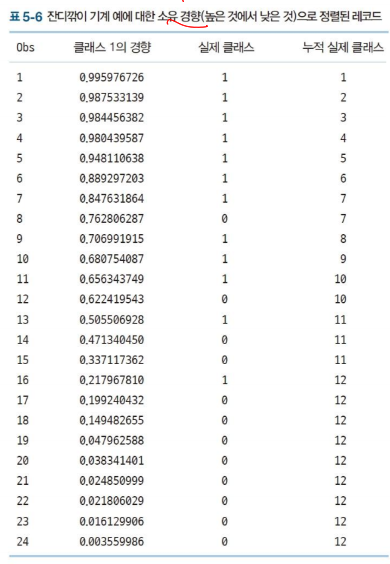  

<Axes: xlabel='# records', ylabel='# cumulative gains'>

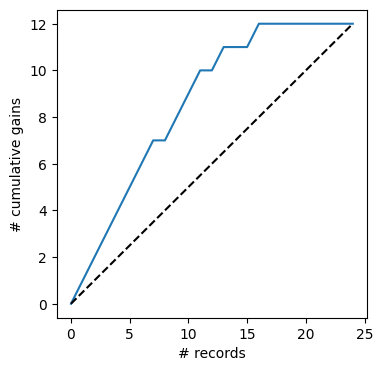

In [12]:
df=dmba.load_data('liftExample.csv')
df=df.sort_values(by=['prob'], ascending=False)
gainsChart(df.actual, figsize=(4, 4))

### 십분위 리프트 차트
* 십분위 리프트차트는 모든 향상 정보를 10개의 그룹으로 집계한다.
* y축상의 막대들은 한 번에 십분위 하나씩 취하면서 우리 모델이 0과 1을 임의로 배정하는 방법을 얼마나 능가하는지 보여준다. 
* 가장 왼쪽 막대를 보면 이 모델에 의한 경향이 가장 커서 '가장 1이 될 가능성이 높다'고 랭크된 레코드들의 10%를 취하면 임의로 10%의 레코드들을 선택하는 것보다 두 배 많은 1을 얻을 수 있음을 알 수 있다.
* 이 예에서 10분위 리프트 차트는 심지어 이 모델을 사용해 경향이 가장 큰 상위 40%의 레코드들을 선택해도 여전히 임의로 선택하는 것보다 두 배 가까운 좋은 성능을 낼 수 있음을 알 수 있다.

<Axes: title={'center': 'Decile Lift Chart'}, xlabel='Percentile', ylabel='Lift'>

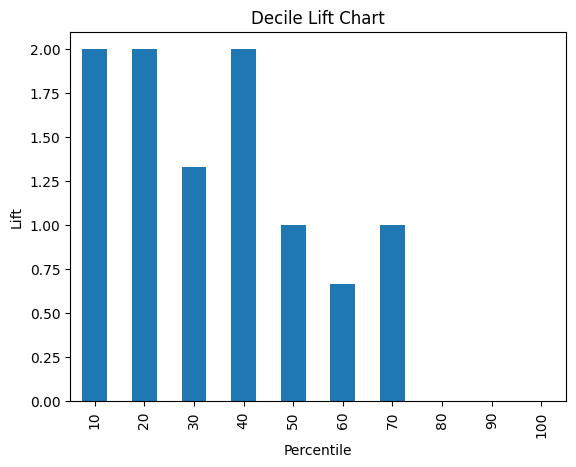

In [13]:
#use liftchart method from utilities
liftChart(df.actual, labelBars=False)

### 비용과 혜택을 포함한 누적 이득 차트와 리프트 차트
1. 레코드들을 예측된 성공 확률의 내림차순으로 정렬한다.(여기서 성공 = 관심 클래스에 속함)
2. 각 레코드에 대해 실제 결과에 수반된 비용(혜택)을 기록한다.
3. 경향이 가장 큰 (즉, 첫 번째) 레코드에 대해 x축 값은 1이고, y축값은 누적 이득 차트상의 (단계 2에서 계산된)비용이나 혜택이다.
4. 다음 레코드에 대해 실제 결과에 수반된 비용(혜택)을 다시 계산한다. 이것을 이전 레코드의 비용(혜택)에 더한다. 이 합이 누적 이득 차트상의 두 번째 점의 y축 촤표다. 이 값에 해당하는 x축 값은 2다.
5. 모든 레코드를 검토할 때까지 단계 4를 반복한다. 모든 점을 연결하면 이것이 누적 이득차트가 된다.
6. 참조선은 원점에서 x=n(n=레코드 수), y=총 순혜택의 점을 잇는 직선이다.

* 예
* 한 사람에게 우편물을 보내는 비용 0.65달러, 응답자의 가치는 25달러, 전체 응답률은 2%인 경우
* 10000명의 사람에게 우편물을 보내는 기대 순가치:
$(0.02*\$25*10000)-(\$0.65*10000)=-\$1500$

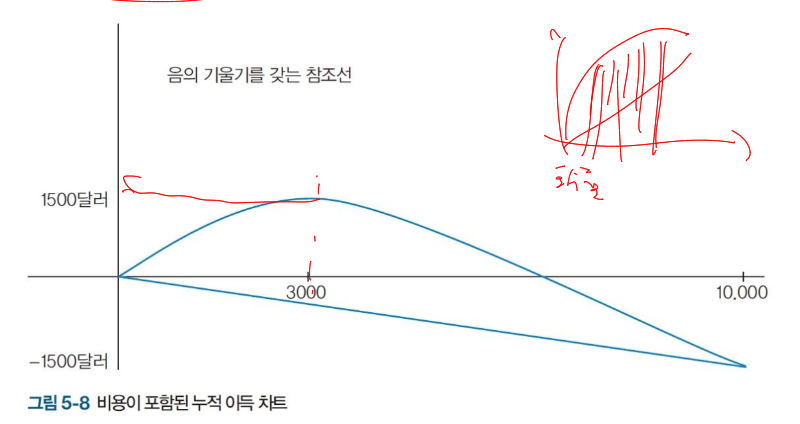

## 오버샘플링
* 단순한 랜덤 샘플링을 사용하면 희귀 클래스를 너무 적게 선택해 우세한 클래스와 구별하기에 유용한 정보를 얻지 못할 수 있음
* 희귀 클래스의 데이터를 더 오버샘플링해 분류기의 성능을 향상하는 데 오버샘플링 사용
* 예: O를 분류하는 데 실패하는 것이 X를 분류하는 데 실패하는 것보다 다섯배 비용이 더 든다고 하면 오분류 비용이 5로 뜀

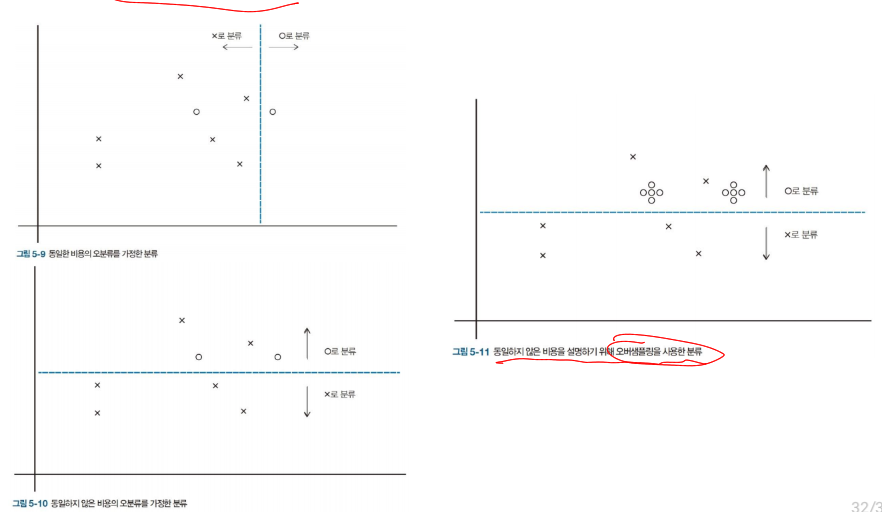

* 학습 데이터셋의 오버샘플링 절차
    1. 응답과 비응답 데이터를 2개의 서로 다른 집합, 즉 계층으로 분리한다.
    2. 학습 데이터셋을 위해 각 계층에서 임의로 레코드들을 선택한다. 보통 학습 데이터셋의 반을 (희귀한)응답자들로 선택하고 동일한 수의 비응답자들을 선택할 수 있다.
    3. 나머지 응답자들을 검증 데이터셋에 넣는다.
    4. 응답자와 비응답자의 원래 비율을 유지하기에 충분한 수의 검증 데이터셋을 위해 임의로 비응답자들을 선택한다.
    5. 테스트 데이터셋이 필요하면 검증 데이터셋에서 임의로 가져올 수 있다.


* 오버샘플링되지 않은 검증 데이터셋을 이용한 모델 성능 평가
    * 오버샘플링된 데이터로 모델을 학습하더라도 원래 데이터로 검증

* 오버샘플링된 검증 데이터셋만 존재하는 경우의 모델 성능 평가
    * 오버샘플링된 데이터를 학습 데이터로만 쓰는 게 아니라 검증 데이터로도 사용
    * 오버샘플링을 위한 정오 행렬의 조정
        * 응답자들: 전체 데이터의 2%, 표본의 50%
        * 비응답자들: 전체 데이터의 98%, 표본의 50%
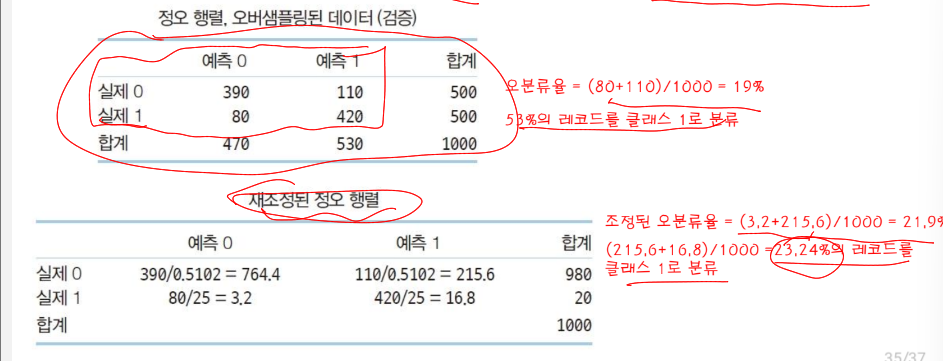

* 오버샘플링된 검증 데이터셋만 존재하는 경우의 모델 성능 평가
    * 오버샘플링을 위한 누적 이득 차트의 조정
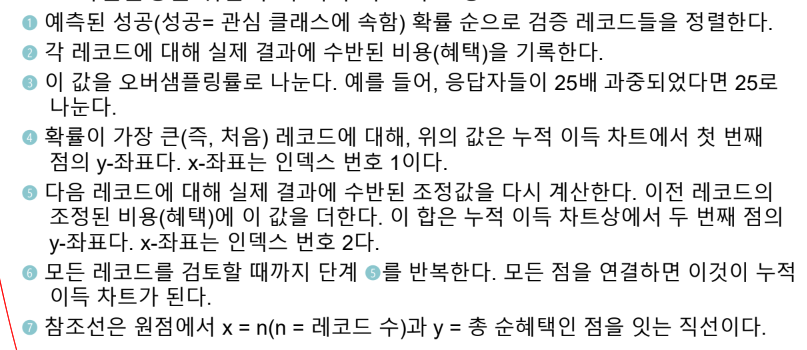